In [1]:
import numpy as np
import scipy.optimize as opt
import scipy.stats as sts
from scipy.special import factorial
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf

In [2]:
e1 = np.transpose(np.loadtxt("e1.csv",delimiter = ",")) 
#one array for each repetition (3)
e1sum = np.transpose(np.loadtxt("e1sum.csv",delimiter = ","))
#horizontal sum of three repetitions, one array

e2 = np.transpose(np.loadtxt("e2.csv",delimiter = ","))
#one array for each repetition (3)
e2sum = np.transpose(np.loadtxt("e2sum.csv",delimiter = ","))
#horizontal sum of three repetitions, one array

e3 = np.transpose(np.loadtxt("e3.csv",delimiter = ","))
#one array for each repetition (20)
e3sum = np.transpose(np.loadtxt("e3sum.csv",delimiter = ","))
#horizontal sum of twenty repetitions, one array
e3sumv = np.transpose(np.loadtxt("e3sumv.csv",delimiter = ","))
#vertical sum of twenty repetitions, one array with 20 entries

e4 = np.transpose(np.loadtxt("e4.csv",delimiter = ","))
#one array for each repetition (5)
e4sum = np.transpose(np.loadtxt("e4sum.csv",delimiter = ","))
#horizontal sum of five repetitions, one array

tech = np.transpose(np.loadtxt("techmon2019.csv",delimiter = ","))
#technician data, one array with 5*5400 entries

ds = [e1,e2,e3,e4]

bg1 = np.transpose(np.loadtxt("bg1.csv",delimiter = ","))
#background radiation for e1
bg2 = np.transpose(np.loadtxt("bg2.csv",delimiter = ","))
#background radiation for e2 and e4
bg3 = np.transpose(np.loadtxt("bg3.csv",delimiter = ","))
#background radiation for e3

bgds=[bg1,bg2,bg3]

In [3]:
def chisq(y,fit,sig):
    """
    Computing chisquare given actual data, best-fit values,
    and corresponding sigma. Histogram entries with
    zero counts (sigma would be zero causing zero division)
    are omitted.
    """
    return np.sum(list(map(lambda a,b,c: (a-b)**2/c**2 
                           if c!=0 else 0,y,fit,sig)))

def Gaussian(x, Amp, u, s):
    """
    Defining the model for Gaussian least-square fitting, 
    where the fit parameters are Amp (amplitude), u (mu)
    and s (sigma).
    """
    return Amp*np.exp(-(x-u)*(x-u)/(2*s*s))/(s*np.sqrt(2*np.pi))

def Gaussianfit(x,y, data):
    """
    Gaussian least-square fitting.
    """
    #estimating fit parameters
    width = 1
    area = y*width
    amp = np.sum(area)
    p,cov = opt.curve_fit(Gaussian,x,y,
                          [amp,np.mean(data),np.std(data)])
    return p,cov

def Poissonian (x, Amp, mu):
    """
    Defining the model for Poissonian least-square fitting, 
    where the fit parameters are Amp (amplitude) and mu.
    """
    return Amp*(mu**x*np.e**(-mu)/factorial(x))

def Poissonfit(x,y, data):
    """
    Poissonian least-square fitting.
    """
    width = 1
    area = y*width
    amp = np.sum(area)
    p,cov = opt.curve_fit(Poissonian,x,y,[amp,np.mean(data)])
    return p,cov

In [216]:
def fithist(data,title='',gaussian=True,poisson=True,both=True):
    """
    Plots histograms with required fit curves 
    (Gaussian or Poissonian)given data.
    """
    val=[]
    fit=[]
    res=[]
    lb=[]
    n=0
    x = np.arange(min(data),max(data)+1,1)
    xfit = np.linspace(min(data),max(data))
    par = {}
    cov = {}
    chi2 = {}
    color=['m','k']
    
    #only plot hist
    if not both:
        height, bins, _ =plt.hist(data,
                                  np.arange(min(data),
                                            max(data)+2,1),
                                  facecolor='skyblue',
                                  align='left',
                                  rwidth=0.95,alpha=0.9)
        plt.errorbar(x,height,yerr=list(map(lambda 
                                            x:np.sqrt(x),height)),
                     capsize=5,fmt='.',marker='',elinewidth=3)
        plt.grid(axis='y')
        plt.title(title)
        plt.xlabel('Counts per time bin', fontsize = 15)
        plt.ylabel('Occurence',fontsize = 15)
        plt.xticks(x)
        plt.show()
        return -1,-1
    
    
    #fig for hist and res
    f,(ax1,ax2)=plt.subplots(2,sharex=True, 
                             gridspec_kw = {'height_ratios':
                                            [2, 1]},figsize=[7,6])
    f.add_subplot(111,frameon=False)
    plt.tick_params(labelcolor = 'none', bottom = False, left = False)
    plt.title(title, fontsize = 15)
    ax1.set_ylabel('Occurence', fontsize = 14)
    ax2.set_xlabel('Counts per time bin', fontsize = 14)
    ax2.set_ylabel('Standardized \n residual', fontsize = 14)   
    ax1.grid(axis='y')
    ax1.tick_params(bottom = False)
    
    if len(x)>20:   
        ax2.set_xticks(np.arange(min(x),max(x)+2,2))
    else:
        ax2.set_xticks(x)
    
    #histogram and error bar
    height, bins, _ = ax1.hist(data,
                               np.arange(min(data),
                                              max(data)+2,1),
                               facecolor='skyblue',
                               align='left',rwidth=0.95,alpha=0.9)
    ey = list(map(lambda x: np.sqrt(x), height))
    if len(x)>20:
        ax1.errorbar(x,height,yerr=ey,capsize=5,fmt='c.',
                 marker='',elinewidth=2)
    else :
        ax1.errorbar(x,height,yerr=ey,capsize=5,fmt='c.',
                 marker='',elinewidth=4)
    
    #gausian fit
    if gaussian:
        n+=1
        lb.append('Gaussian fit')
        par['gaussian'],cov['gaussian']=Gaussianfit(bins[:-1],
                                                    height,data)
        fit.append(Gaussian(np.linspace(min(data),max(data)),
                            *(par['gaussian'])))
        val.append(Gaussian(x,*(par['gaussian'])))
        chi2['gaussian']=chisq(height,val[n-1],ey)
    
    #poissonian fit
    if poisson:
        n+=1
        lb.append('Poissonian fit')
        par['poisson'],cov['poisson']=Poissonfit(np.arange(min(data),
                                                           max(data)+1,1),
                                                 height,data)
        fit.append(Poissonian(np.linspace(min(data),max(data)),
                              *(par['poisson'])))
        val.append(Poissonian(x,*(par['poisson'])))
        chi2['poisson']=sts.chisquare(height,val[n-1])#chisq(height,val[n-1],ey)
    
    #fit and residual plot
    for i in range(n):
        ax1.plot(xfit,fit[i],(color[i]+':'),label = lb[i])
        res.append((height-val[i])/(np.sqrt(sum(list(map(lambda x,
                                                 y: (x-y)**2,height,
                                                 val[i])))/(len(height)-2))))
        
        ax2.plot(x,res[i],(color[i]+'o'),markersize = 3)
        ax2.errorbar(x,res[i],yerr=((np.sqrt(height))/
                                    (np.sqrt(sum(list(map(lambda x,
                                                 y: (x-y)**2,height,
                                                 val[i])))/(len(height)-2)))),
                     capsize=5,fmt='c.',marker='',elinewidth=2)
        
    ax2.plot(x,[0]*len(x),'orange')
    
    ax1.legend(loc=1, prop = {'size' : 12})
    #plt.show()
    print(res[0])
    print(height[0])
    print((np.sqrt(height[0]))/(np.sqrt(sum(list(map(lambda x,
                                                 y: (x-y)**2,height,
                                                 val[i])))/(len(height)-2))))
    return par,cov,chi2,f

0.08928269263925424 0.8436425301086504 0.0621572745269046


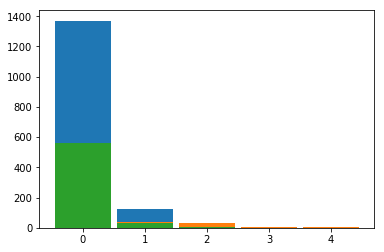

In [5]:
mu=[]
for x in bgds:
    h,bins,_=plt.hist(x,np.arange((min(x)),
                                  (max(x))+2,1),
                      rwidth=0.9,align='left')
    p,_=Poissonfit(np.arange(0,len(h),1),h,x)
    mu.append(p[1])

bgr1,bgr2,bgr3=mu
print(bgr1,bgr2,bgr3)

In [56]:
h_sums_g = []
h_sums_p = []

sums = [e1sum,e2sum,e3sum]
for x in sums:
    p,c,_,f= fithist(x)
    h_sums_g.append(p['gaussian'][1])
    h_sums_p.append(p['poisson'][1])
    plt.close(f)
    print (p['gaussian'][1], p['gaussian'][2], p['poisson'][1], np.sqrt(c['poisson'][1][1]))
crc_h_sums_g = ([(h_sums_g[0]-bgr1)*5/3]+
               [(h_sums_g[1]-bgr2)/2/3]+
               [(h_sums_g[2]-bgr3)*10/20])
               
crc_h_sums_p = ([(h_sums_p[0]-bgr1)*5/3]+
               [(h_sums_p[1]-bgr2)/2/3]+
               [(h_sums_p[2]-bgr3)*10/20])
print (crc_h_sums_g,crc_h_sums_p )

10.24467631593078 3.222349036060191 10.49588403737464 0.08928364154524124
102.44509037868441 10.331186754719937 102.69633698602921 0.9742382701236904
34.703946537117 5.8241763462829255 34.95799875155716 0.24597886872583805
[16.925656038819213, 16.933574641429292, 17.320894631295047] [17.34433557455898, 16.97544907598676, 17.44792073851513]


[1072. 1062. 1031. 1053.  962. 1062. 1091. 1083. 1067. 1056. 1039. 1067.
 1042. 1105. 1036. 1045. 1043. 1015. 1083.  969.]
[ 962.   976.3  990.6 1004.9 1019.2 1033.5 1047.8 1062.1 1076.4 1090.7]
[104.9 119.2 133.5 147.8 162.1 176.4 190.7] [1. 1. 5. 4. 3. 2. 2.]


D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in power
D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in true_divide


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 600.

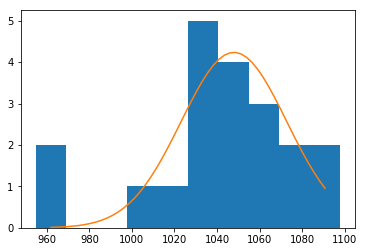

In [159]:
h,bin,_=plt.hist(e3sumv,align='left')
print((e3sumv))
x=bin[:-1]
print(x)
pg,c= opt.curve_fit(Gaussian,x,h,[10,np.mean(e3sumv),np.std(e3sumv)])
x=np.linspace(min(x),max(x))
y=Gaussian(x,*pg)
plt.plot(x,y)

x=bin[3:-1]-900
print(x,h[3:])
p,c= opt.curve_fit(Poissonian,x,h[3:],[300,np.mean(e3sumv)-900])
x=np.linspace(min(x),max(x))
y=Poissonian(x,*p)
plt.plot(x+900,y)
plt.show()

[3.222349036060191, 10.331186754719937, 5.8241763462829255, 4.767217328932594]
[3.2397351801304133, 10.133920119382687, 5.912528964119936, 5.3365399616515425]


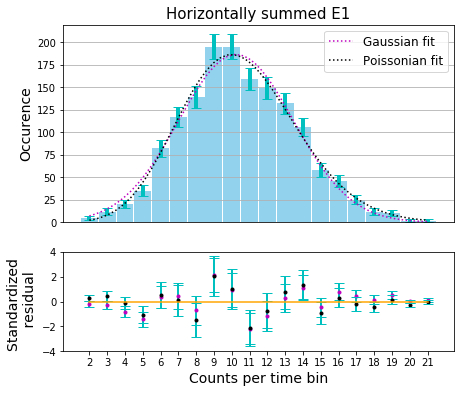

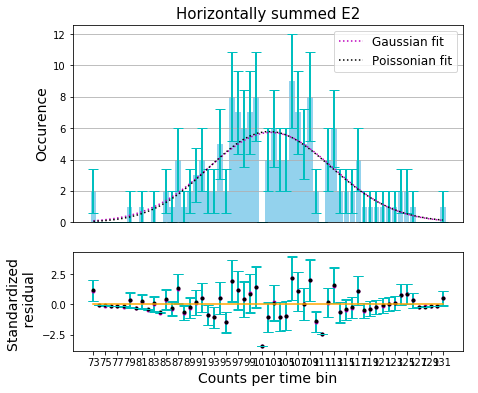

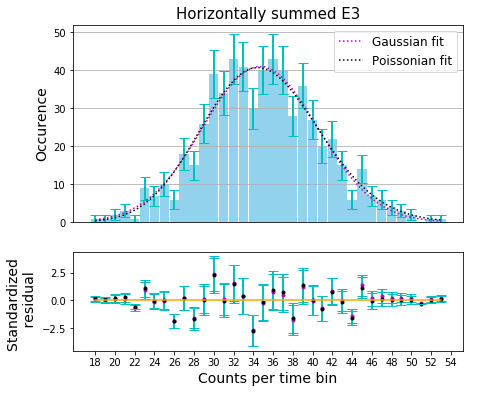

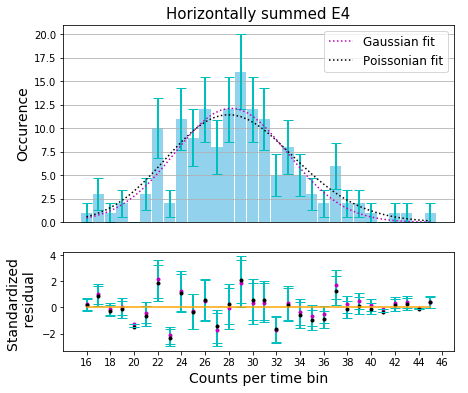

In [7]:
esum = [e1sum,e2sum,e3sum,e4sum]
i=0
#pdf = matplotlib.backends.backend_pdf.PdfPages("H-sum.pdf")
sumperr=[]
sumgerr=[]
for x in esum:
    i+=1
    p,_,_,f=fithist(x,'Horizontally summed E{}'.format(i))
    sumgerr.append(p['gaussian'][2])
    sumperr.append(np.sqrt(p['poisson'][1]))
    #pdf.savefig(f)
#pdf.close()
print(sumgerr)
print(sumperr)

{'gaussian': array([4.52251641e+03, 3.22006171e+00, 1.82580023e+00]), 'poisson': array([4.53918249e+03, 3.48873937e+00])}
{'gaussian': array([434.3040571 ,  33.95361651,   5.55576636]), 'poisson': array([444.95865432,  34.22356667])}
{'gaussian': array([1.29665880e+04, 1.36981417e+00, 1.44698116e+00]), 'poisson': array([1.19313555e+04, 1.72303170e+00])}
{'gaussian': array([740.61154461,   5.44290779,   2.27356746]), 'poisson': array([755.97623623,   5.71136017])}
[['Combined Gaussian E1', 3.220061709404919, 1.8258002288736546], ['Combined Poisson E1', 3.4887393669989666, 1.867816738065854], ['Combined Gaussian E2', 33.95361651306012, 5.5557663640828], ['Combined Poisson E2', 34.22356667213324, 5.850091167848006], ['Combined Gaussian E3', 1.3698141688429217, 1.4469811630798468], ['Combined Poisson E3', 1.723031704336831, 1.3126430224310153], ['Combined Gaussian E4', 5.442907786081534, 2.27356745872694], ['Combined Poisson E4', 5.711360174387597, 2.389845219755371]]


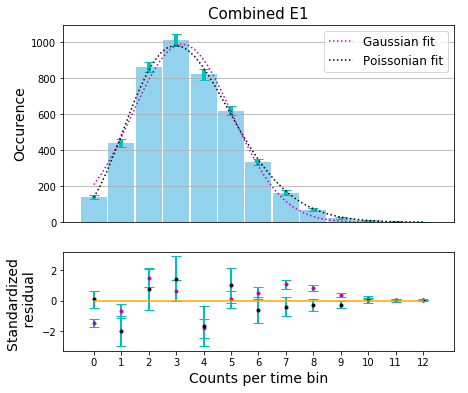

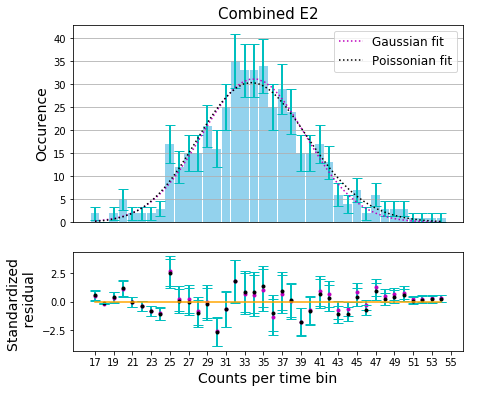

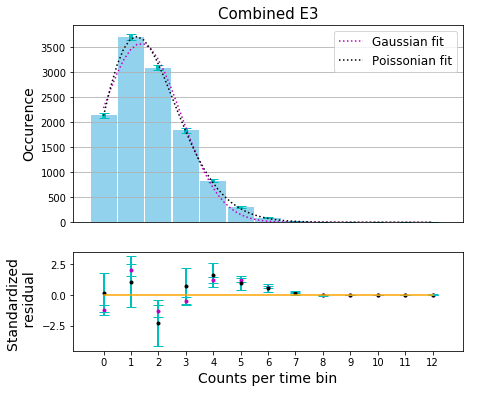

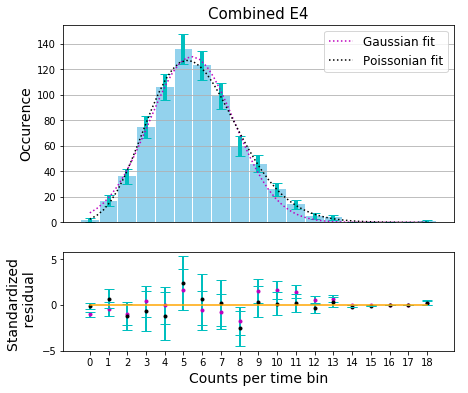

In [8]:
#shows the histograms for all repetitions combined
e1t = np.ravel(e1)
e2t = np.ravel(e2)
e3t = np.ravel(e3)
e4t = np.ravel(e4)
et = [e1t,e2t,e3t,e4t]

i=0
results = []
#pdf = matplotlib.backends.backend_pdf.PdfPages("total.pdf")
for x in et:
    i+=1
    p,_,_,f=fithist(x,'Combined E{}'.format(i))
    print (p)
    results.append(['Combined Gaussian E{}'.format(i),
                    p['gaussian'][1],p['gaussian'][2]])
    results.append(['Combined Poisson E{}'.format(i),
                    p['poisson'][1],np.sqrt(p['poisson'][1])])
    #pdf.savefig(f)
#pdf.close()
print(results)

In [9]:
#print out chisquares
i=j=0
fig=[]
for x in ds:
    i+=1
    j=0
    for y in x:
        j+=1
        _,_,c,f=fithist(y,'e{}r{}'.format(i,j))
        print(c)
        plt.close(f)
        #fig.append(f)
        
#pdf = matplotlib.backends.backend_pdf.PdfPages("output.pdf")
'''for fg in fig:
    #pdf.savefig( fg )
    plt.close(fg)
#pdf.close()'''

{'gaussian': 67.54320855084109, 'poisson': Power_divergenceResult(statistic=17.358980793439407, pvalue=0.1365852897752685)}
{'gaussian': 44.4882876907331, 'poisson': Power_divergenceResult(statistic=12.536877969912275, pvalue=0.3246683594243285)}
{'gaussian': 23.002313273070783, 'poisson': Power_divergenceResult(statistic=15.384863828981237, pvalue=0.2210609692256788)}
{'gaussian': 32.54285473006069, 'poisson': Power_divergenceResult(statistic=57.30757962613194, pvalue=0.0074567745468050745)}
{'gaussian': 35.756608481848026, 'poisson': Power_divergenceResult(statistic=52.185495590184416, pvalue=0.03094593506498338)}
{'gaussian': 28.327628705032144, 'poisson': Power_divergenceResult(statistic=63.29322827497729, pvalue=0.0016744095168021184)}
{'gaussian': 8.123598911977785, 'poisson': Power_divergenceResult(statistic=0.9543308376907979, pvalue=0.9872844199629294)}
{'gaussian': 9.116636112299723, 'poisson': Power_divergenceResult(statistic=3.7303774966502137, pvalue=0.7131087303975421)}
{

'for fg in fig:\n    #pdf.savefig( fg )\n    plt.close(fg)\n#pdf.close()'

D:\Anaconda3\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[3.1719566275339584, 3.2382541547139763, 3.250588057979457, 33.83712115823718, 33.91062707391176, 34.133570116079774, 1.4895664233746642, 1.4356998017947136, 1.3030291584155718, 1.3409693648184826, 1.1999856861536873, 1.402761357309651, 1.443095531250009, 1.3019115013191902, 1.4031140181429764, 1.3119608336815167, 1.4329071782939005, 1.494151945855046, 1.37723404129737, 1.4916911272148474, 1.30804182557128, 1.3689278256127526, 1.3445225871682152, 1.3668234697939698, 1.3470912562392645, 1.2301070295177055, 5.571067139053714, 5.387365642096429, 5.1400481916286935, 5.443883639833423, 5.539219505033002]
[3.446619129825039, 3.4990734718954326, 3.518145989960904, 34.12597893975741, 34.16376188311434, 34.4000975380903, 1.8146759998479662, 1.7758029193219322, 1.6785314783016676, 1.7010030439964532, 1.5633945588664813, 1.7584695996908468, 1.780649582206512, 1.708408668645374, 1.7841366012328543, 1.667677225932239, 1.7501382623642865, 1.8152551669792167, 1.7343165920970196, 1.8479668718338316, 1

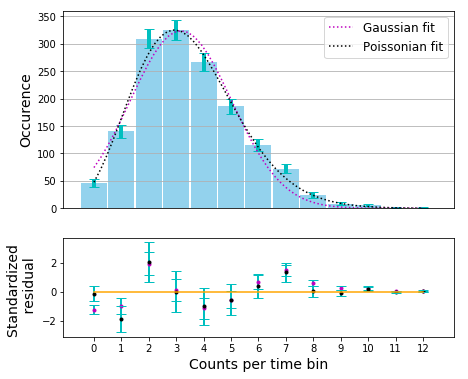

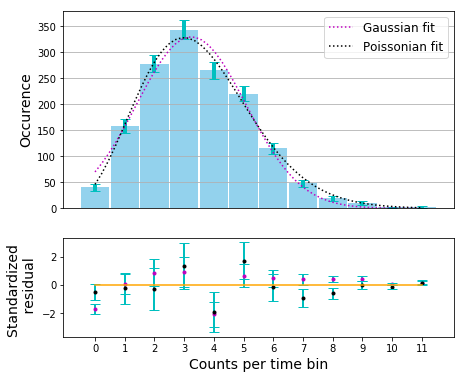

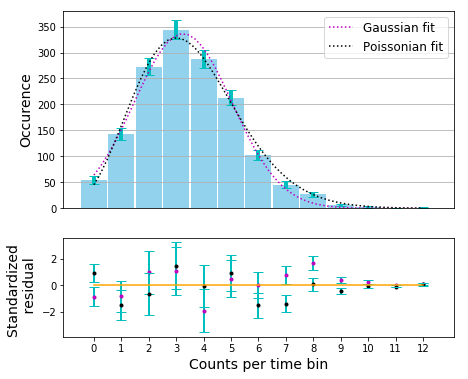

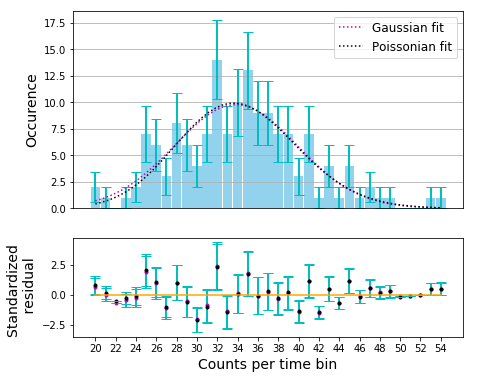

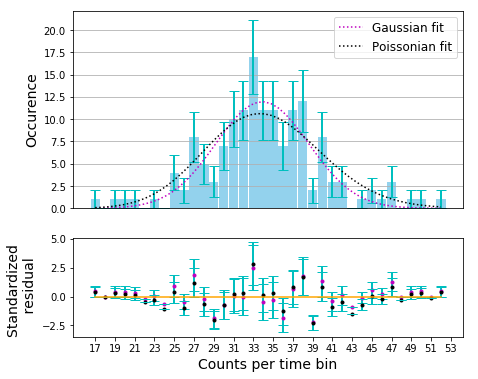

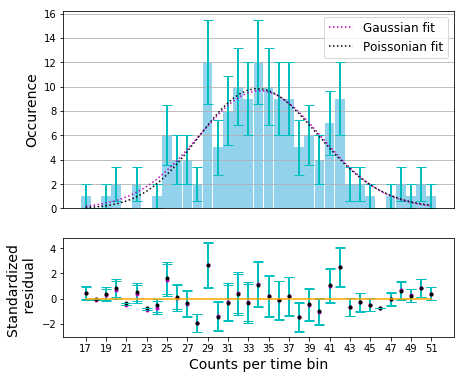

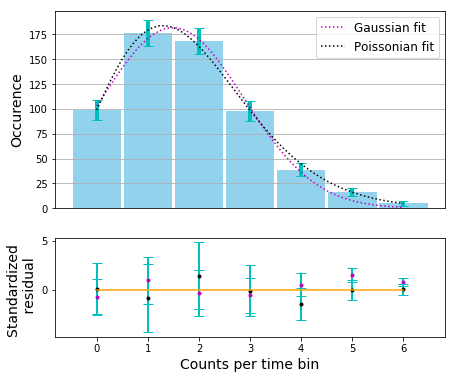

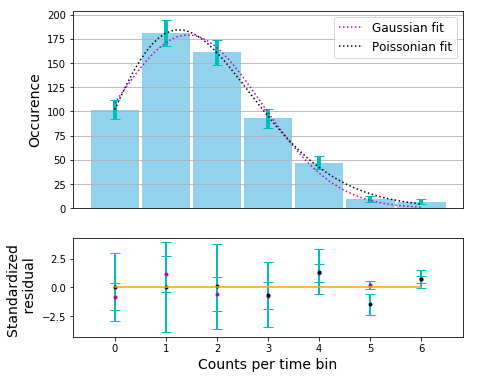

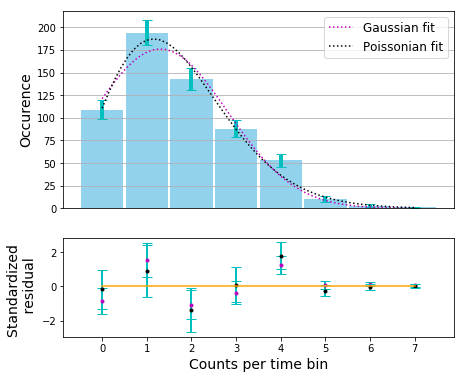

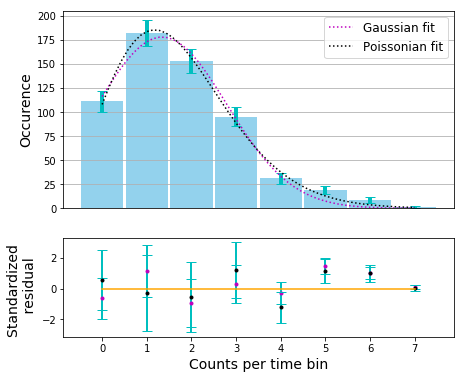

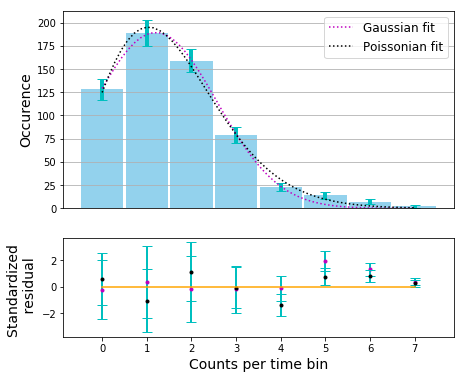

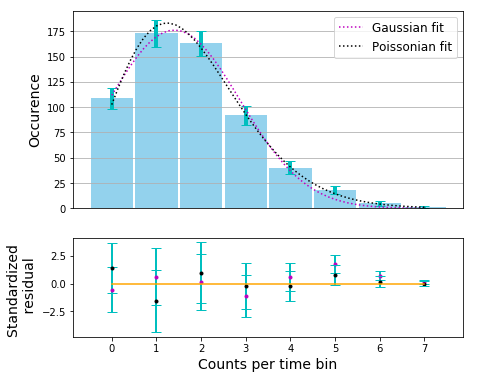

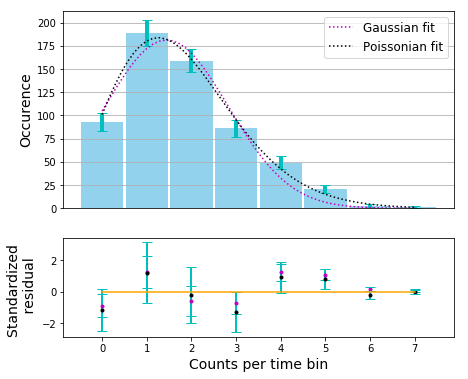

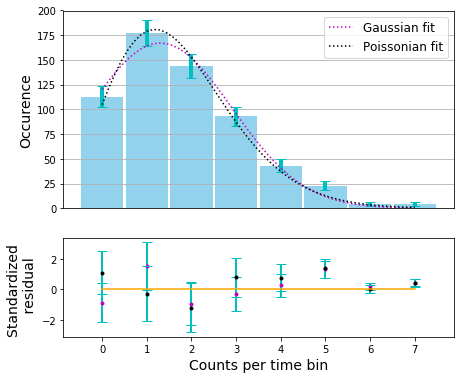

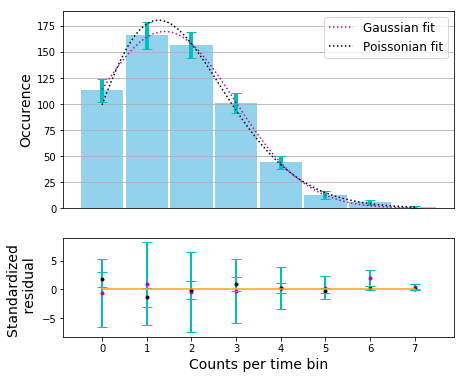

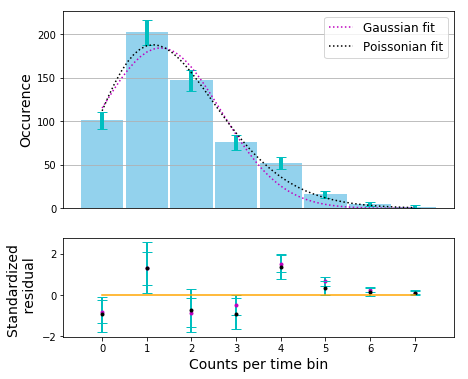

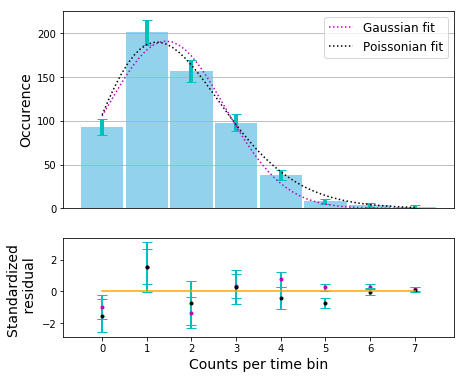

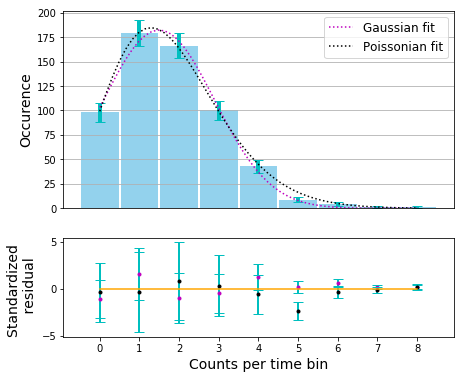

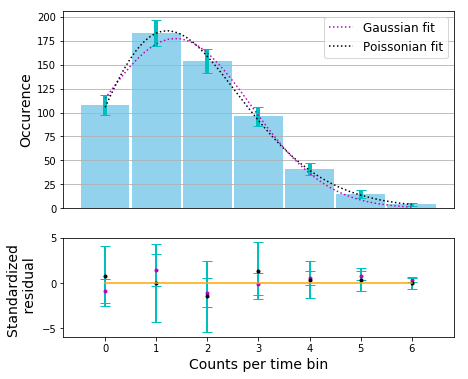

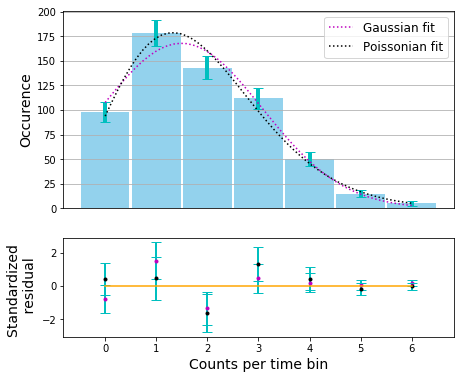

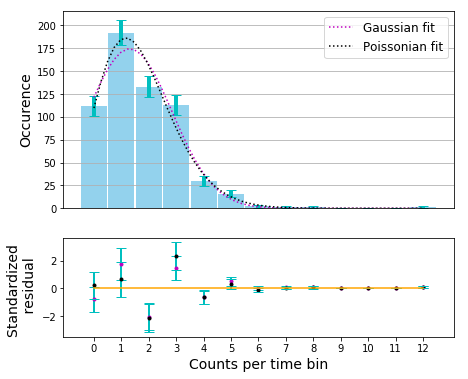

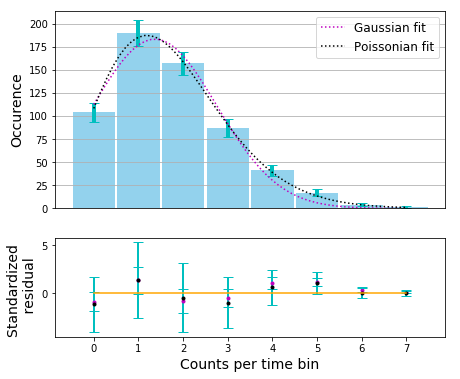

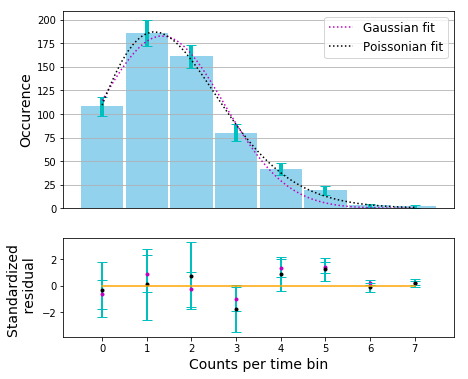

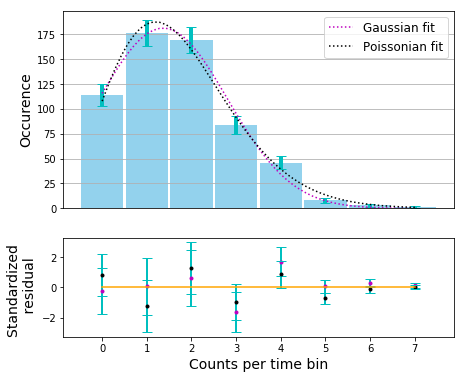

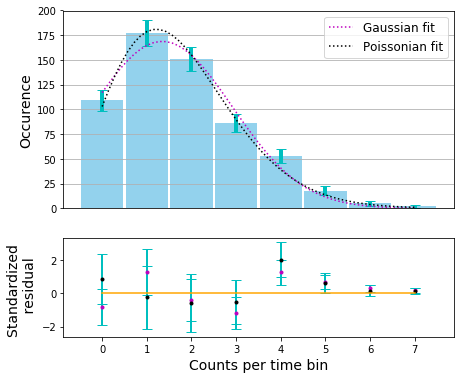

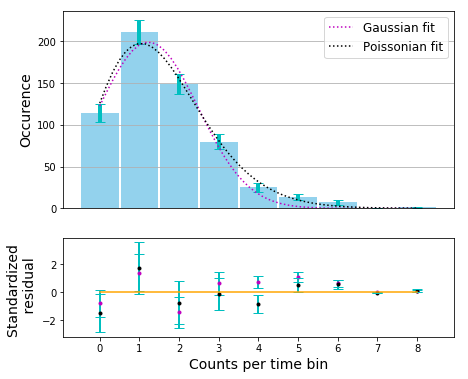

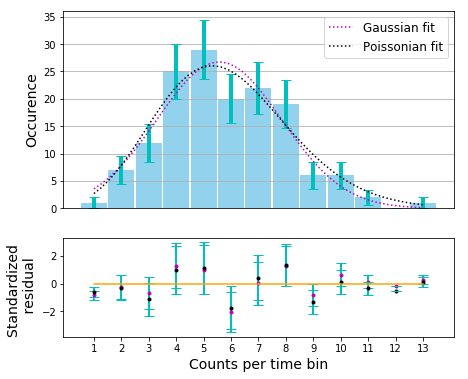

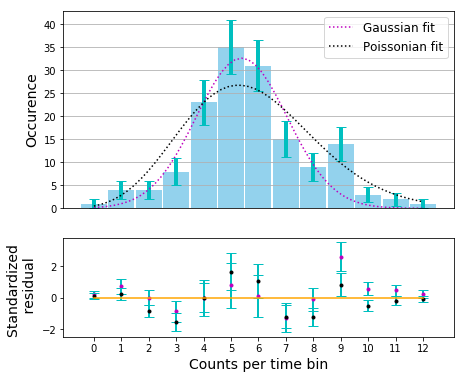

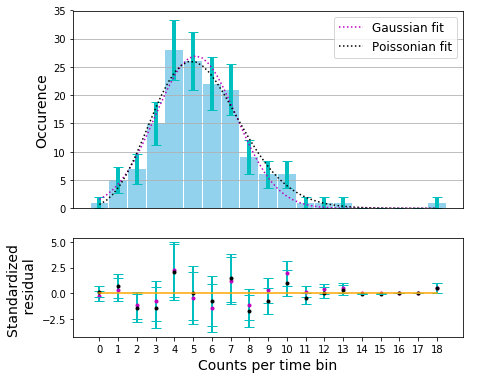

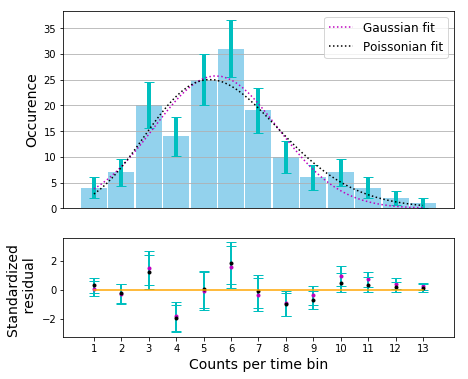

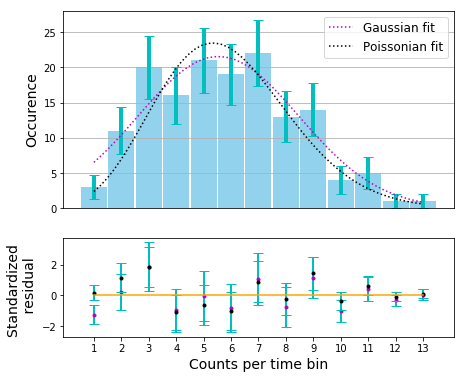

In [191]:
pg=[]
pp=[]
e=[]
for x in ds:
    for y in x:
        p,_,_,_=fithist(y)
        pg.append(p['gaussian'][1])
        pp.append(p['poisson'][1])
        e.append(p['gaussian'][2])
print(pg) 

print(pp)
print(e[0])

#shows the count rates determined 
#from each repetition of each experiment

In [11]:
#Corrected count rates (count per second) considering
#background radiation

crctg=(list(map(lambda x: (x-bgr1)*5, pg[:3]))+
       list(map(lambda x: (x-bgr2)/2, pg[3:6]))+
       list(map(lambda x: (x-bgr3)*10, pg[6:6+20]))+
       list(map(lambda x: (x-bgr2)/2, pg[6+20:])))
print(crctg)
crctp=(list(map(lambda x: (x-bgr1)*5, pp[:3]))+
       list(map(lambda x: (x-bgr2)/2, pp[3:6]))+
       list(map(lambda x: (x-bgr3)*10, pp[6:6+20]))+
       list(map(lambda x: (x-bgr2)/2, pp[6+20:])))
print(crctp)

[15.41336967447352, 15.744857310373611, 15.806526826701013, 16.496739314064264, 16.533492271901554, 16.64496379298556, 14.274091488477596, 13.73542527267809, 12.408718838886672, 12.78812090291578, 11.378284116267828, 13.406040827827464, 13.809382567231044, 12.397542267922857, 13.409567436160719, 12.498035591546122, 13.707499037669958, 14.319946713281414, 13.150767667704654, 14.295338526879428, 12.458845510443755, 13.067705510858481, 12.823653126413106, 13.046661952670654, 12.8493398171236, 11.679497549908008, 2.3637123044725317, 2.2718615559938895, 2.1482028307600216, 2.3001205548623864, 2.347788487462176]
[16.786682185928925, 17.048953896280892, 17.144316486608247, 16.64116820482438, 16.660059676502843, 16.778227503990824, 17.525187253210618, 17.136456447950277, 16.16374203774763, 16.388457694695486, 15.012372843395767, 16.963123251639423, 17.184923076796075, 16.462513941184696, 17.219793267059497, 16.055199514053346, 16.87980987837382, 17.530978924523122, 16.721593175701152, 17.85809

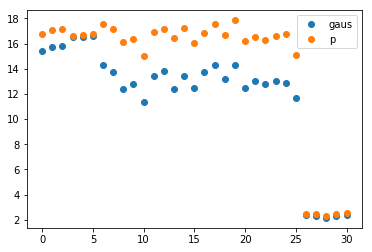

In [12]:
plt.plot(np.arange(0,len(crctg),1),crctg,'o',label='gaus')
plt.plot(np.arange(0,len(crctp),1),crctp,'o',label='p')
plt.legend()
plt.show()

[8.255552050477796, 9.85783503236275]
[1.4809561701049063, 1.4041249967408707]


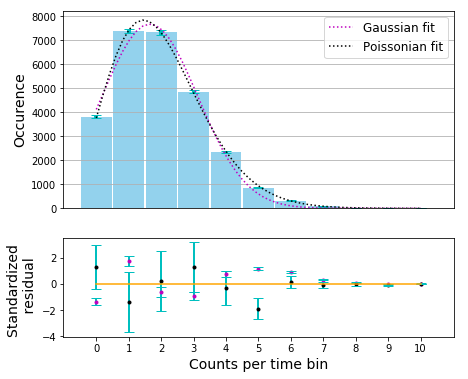

In [13]:
# tech
p,cov,c,f=fithist(tech)
utech = [p['gaussian'][1]*5,p['poisson'][1]*5]
utecherr = [p['gaussian'][2],np.sqrt(p['poisson'][1])]
print(utech)
print(utecherr)

In [197]:
print(e[:3])
x=crctg[:3]
m=np.sqrt((1/3)**2*e[0]**2+(1/3)**2*e[1]**2+(1/3)**2*e[2]**2)
print(5*m)

[1.8485164053984884, 1.839599300805155, 1.7847407703282303]
5.266887681497058


[16.55498699 16.68996207 13.07656894 16.6087443 ]
[15.41336967447352, 15.744857310373611, 15.806526826701013]
15.654917937182717
asd5.267830805464405
16.993317522939353
[3.446619129825039, 3.4990734718954326, 3.518145989960904]
err[ 2.35606192  2.50322432 13.84823889 12.50485748]
[16.925656038819213, 16.933574641429292, 17.320894631295047]
[17.34433557455898, 16.97544907598676, 17.44792073851513]
[5.221777239034895, 1.5812573707685476, 2.8810095358780106] [5.250754145818598, 1.5483795982123392, 2.9251858447965158]
[15.654917937182717, 16.993317522939353, 16.925656038819213, 17.34433557455898, 16.554986991475733, 16.689962071012292, 16.933574641429292, 16.97544907598676, 13.076568943160172, 16.608744298099264, 17.320894631295047, 17.44792073851513]
[5.267830805464405, 2.3235600059283557, 5.221777239034895, 5.250754145818598, 2.3560619169870747, 2.5032243188696777, 1.5812573707685476, 1.5483795982123392, 13.848238885529423, 12.504857479041107, 2.8810095358780106, 2.9251858447965158]


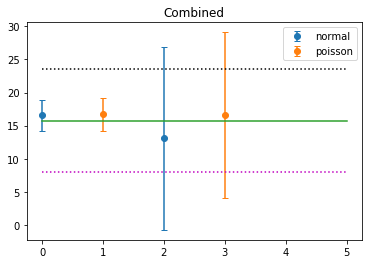

In [198]:
u_comb=[results[i][1] for i in range(2,len(results)-2)]
u_comb=np.ravel([(u_comb[0:2]-bgr2)/2]+[(u_comb[2:4]-bgr3)*10])
print(u_comb)
avg1g = np.mean(crctg[:3])
print(crctg[:3])
print(avg1g)
avg1gerr = np.sqrt((np.std(crctg[:3])/np.sqrt(3))**2+(5*m)**2)
print('asd'+str(avg1gerr))
avg1p = np.mean(crctp[:3])
print(avg1p)
print(pp[:3])
avg1perr=np.sqrt((np.std(crctp[:3])/np.sqrt(3))**2+(5*np.sqrt((np.sqrt(pp[0])/3)**2+(np.sqrt(pp[1])/3)**2+(np.sqrt(pp[2])/3)**2)))

err=[results[i][2] for i in range(2,len(results)-2)]
err=np.ravel([(err[0:2]-bgr2)/2]+[(err[2:4]-bgr3)*10])
print('err'+str(err))


gusum= crc_h_sums_g
print(gusum)
pusum=crc_h_sums_p
print(pusum)

gusumerr = ([(sumgerr[0]-bgr1)*5/3]+
               [(sumgerr[1]-bgr2)/2/3]+
               [(sumgerr[2]-bgr3)*10/20])

pusumerr = ([(sumperr[0]-bgr1)*5/3]+
               [(sumperr[1]-bgr2)/2/3]+
               [(sumperr[2]-bgr3)*10/20])
print(gusumerr,pusumerr)

u=([avg1g,avg1p,gusum[0],pusum[0]]+list(u_comb[:2])+[gusum[1],pusum[1]]+list(u_comb[2:])+[gusum[2],pusum[2]])
print(u)
uerr=([avg1gerr,avg1perr,gusumerr[0],pusumerr[0]]+
      list(err[:2])+[gusumerr[1],pusumerr[1]]+list(err[2:])+[gusumerr[2],pusumerr[2]])
print(uerr)

plt.errorbar(np.arange(0,len(u_comb),2),u_comb[::2],yerr=err[::2],fmt='o',capsize=3, label='normal')
plt.errorbar(np.arange(1,len(u_comb),2),u_comb[1::2],yerr=err[1::2],fmt='o',capsize=3,label='poisson')
plt.plot([0,5],[np.mean(u_comb)]*2)
plt.plot([0,5],[np.mean(u_comb+err)]*2,'k:')
plt.plot([0,5],[np.mean(u_comb-err)]*2,'m:')

plt.title('Combined')
plt.legend()
plt.show()

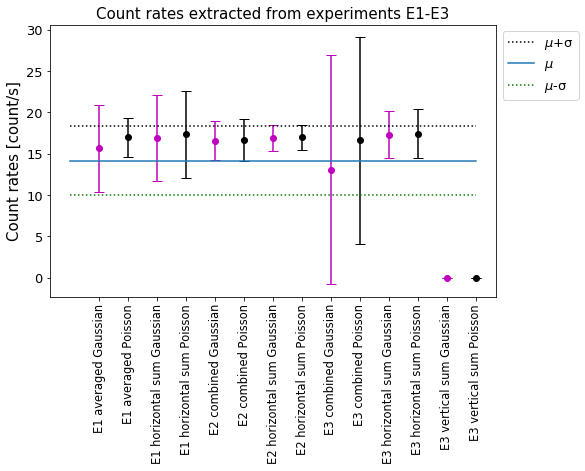

In [200]:
names = ['E1 averaged Gaussian','E1 averaged Poisson',
         'E1 horizontal sum Gaussian','E1 horizontal sum Poisson',
         'E2 combined Gaussian','E2 combined Poisson',
         'E2 horizontal sum Gaussian','E2 horizontal sum Poisson',
         'E3 combined Gaussian','E3 combined Poisson',
         'E3 horizontal sum Gaussian','E3 horizontal sum Poisson',
         'E3 vertical sum Gaussian','E3 vertical sum Poisson']
means = np.array(u+[0,0])
err_result = np.array(uerr+[0,0])
plt.figure(figsize = [8,5])
plt.xticks([1,2,3,4,5,6,7,8,9,10,11,12,13,14], 
           names, rotation=90, fontsize = 11.5)
for i in list(range (1,15)):
    if i%2 != 0:
        plt.errorbar(i,means[i-1],yerr=err_result[i-1],fmt = 'mo', capsize = 5)
    else:
        plt.errorbar(i,means[i-1],yerr=err_result[i-1],fmt = 'ko', capsize = 5)


plt.plot([0,14], [np.mean(means+err_result)]*2 , 'k:', label = '$\mu$+σ')
plt.plot([0,14], [np.mean(means)]*2, label = '$\mu$')
plt.plot([0,14], [np.mean(means-err_result)]*2 , 'g:', label = '$\mu$-σ')

#plt.xlabel("Different entries", fontsize = 15)
plt.ylabel("Count rates [count/s]", fontsize = 15)

plt.tick_params ('y', labelsize = 13)
plt.title(
    "Count rates extracted from experiments E1-E3", 
    fontsize = 15)
plt.legend(bbox_to_anchor=(1, 1), loc = 2, prop={'size':13})
plt.show()

In [205]:
print(err_result[8])
print(err_result[9])
print(1/err_result[8])
print(1/err_result[9])

13.848238885529423
12.504857479041107
0.07221134819135305
0.07996892421013675


[-1.23664063 -0.97428798  1.94365552  0.12492748 -1.12423671 -0.54388469
  0.68400895  1.49382387  0.58355252  0.25209845  0.24743712  0.04200475
  0.04365542]
46.0
0.2971576622102458


({'gaussian': array([1499.16227629,    3.17195663,    1.84851641])},
 {'gaussian': array([[ 5.91985348e+03, -2.79169719e-01,  5.21781626e+00],
         [-2.79169719e-01,  1.16902921e-02, -5.70216164e-04],
         [ 5.21781626e+00, -5.70216164e-04,  1.26209943e-02]])},
 {'gaussian': 67.54320855084109},
 <Figure size 504x432 with 3 Axes>)

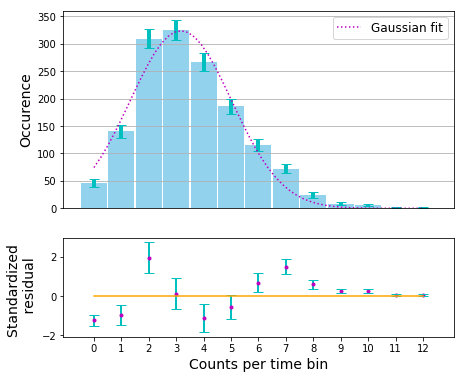

In [217]:
fithist(e1[0],poisson=False)